# Lezione 8 − Quadratura numerica

In questo notebook Julia mostro come implementare gli algoritmi di integrazione numerica visti durante la lezione 8. È una utile traccia per capire quali risultati dovete aspettarvi, e il fatto di implementare i codici in Julia impedisce semplici soluzioni copia-e-incolla: in Julia non esiste incapsulamento, e l'ereditarietà e il polimorfismo sono implementati in maniera diversa dal C++, quindi il modo in cui sono implementati i codici è profondamente diverso.

In [1]:
using PyPlot
using Printf

Useremo come riferimento la funzione $f(x) = \sin(x)$, sapendo che
$$
\int_0^\pi \sin x\,\text{d}x = 2.
$$

Useremo molto anche la capacità di Julia di creare liste al volo mediante la sintassi

```julia
result = [f(x) for x in lista]
```
che equivale al codice seguente:
```julia
result = []
for elem in lista
    append!(result, f(elem))
end
```

## Metodo del mid-point

Il metodo del mid-point consiste nell'approssimare l'integrale con il valore del punto della funzione $f$ nel punto medio dell'intervallo:
$$
\int_a^b f(x)\,\text{d}x \approx \sum_{k=0}^{n - 1} f\Biggl(a + \left(k + \frac12\right)h\Biggr).
$$

In Julia non esistono classi, quindi non è possibile definire una classe `Integral`. Ma ciò non è necessario, perché in Julia il polimorfismo non viene implementato tramite classi, bensì tramite il cosiddetto _multiple dispatch_, più adatto ai casi numerici e scientifici. Implementiamo quindi il metodo del mid-point tramite una funzione `midpoint`. Non specifichiamo il tipo di `f`, né di `a` o di `b`, ma specifichiamo quello di `n`: il motivo sarà chiaro quando risolveremo l'esercizio 8.2. Il tipo `Integer` è l'analogo di una classe astratta in C++, ed è il padre di tutti quei tipi che rappresentano numeri interi (`Int`, `Int8`, `UInt32`, etc.)

In [2]:
function midpoint(f, a, b, n::Integer)
    h = (b - a) / n
    h * sum([f(a + (k + 0.5) * h) for k in 0:(n - 1)])
end

midpoint (generic function with 1 method)

Verifichiamone il funzionamento:

In [3]:
midpoint(sin, 0, pi, 10)

2.0082484079079745

Questo caso è utile per implementare nel vostro codice un `assert`:

```c++
const double REF_A = 0.0;
const double REF_B = M_PI;
const double REF_INTEGRAL = 2.0;

int main(void) {
    Seno mysin();
    Integrator integrator(REF_A, REF_B, &mysin);
    assert(fabs(integrator.MidPoint(10) - REF_INTEGRAL) < 1e-5);
}
```

In [4]:
midpoint(sin, 0, pi, 100)

2.000082249070986

In [5]:
midpoint(sin, pi, 0, 10)

-2.0082484079079745

Notate la semplicità con cui è stata chiamata la funzione: a differenza della programmazione OOP in C++, qui non abbiamo dovuto creare una classe `Seno` con un metodo `Eval` che chiamasse `sin`, è stato sufficiente invocare `midpoint` passandole `sin` come primo argomento.

Calcoliamo ora l'andamento dell'errore rispetto alla funzione di riferimento $f(x) = \sin x$.

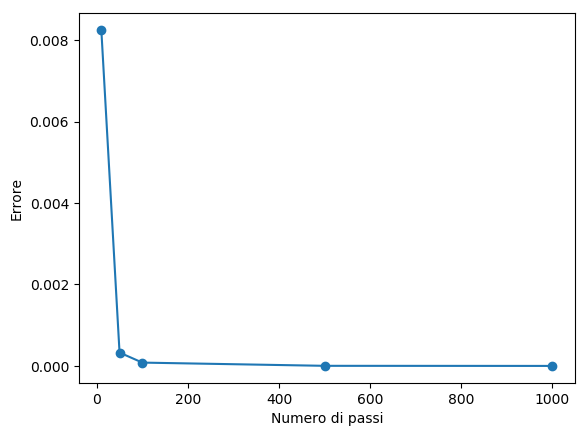

In [6]:
steps = [10, 50, 100, 500, 1000]
errors = [abs(midpoint(sin, 0, pi, n) - 2) for n in steps]

plot(steps, errors, "o-");
xlabel("Numero di passi");
ylabel("Errore");

Il grafico precedente non è chiaro perché ci sono escursioni di alcuni ordini di grandezza sia per la variabile $x$ che per la variabile $y$. Usiamo allora un grafico bilogaritmico, in cui si rappresentano i punti $(x', y') = (\log x, \log y)$ anziché $(x, y)$. Questo è l'ideale per i grafici di leggi del tipo $y = x^\alpha$, come si vede da questi conti:
$$
\begin{split}
y &= C x^\alpha,\\
\log y &= \log \bigl(C x^\alpha\bigr),\\
\log y &= \alpha \log x + \log C,\\
y' &= \alpha x' + \log C,
\end{split}
$$
che è della forma $y' = m x' + q$, ossia una retta, dove il coefficiente angolare $m$ è proprio $\alpha$.

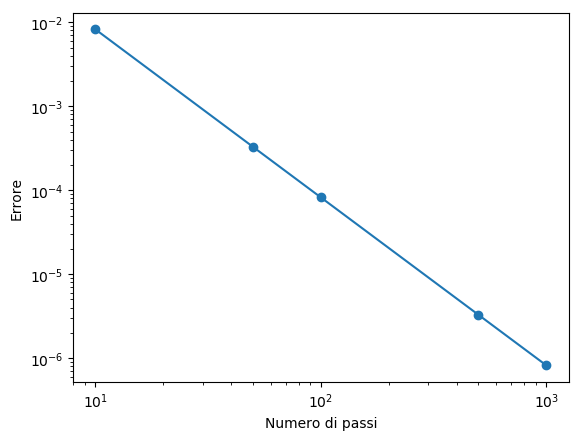

In [7]:
loglog(steps, errors, "o-");
xlabel("Numero di passi");
ylabel("Errore");

Siccome la realizzazione di grafici in ROOT può essere complessa, il mio consiglio è quello di stampare dapprima i numeri in un file (oppure a video, reindirizzando l'output da linea di comando con il carattere `>`), e poi fare una veloce visualizzazione con Gnuplot. Sono sufficienti questi comandi:

    set logscale xy
    plot 'dati.txt' using 1:2 with linespoints
    
Quando avrete verificato che il plot è simile a quello mostrato sopra, potrete a questo punto implementare il codice per disegnare grafici con ROOT.

Implementiamo ora una funzione che consenta di calcolare rapidamente l'errore di una funzione di integrazione numerica per un dato numero di passi di integrazione: ci servirà per studiare non solo il metodo del mid-point, ma anche i metodi di Simpson e dei trapezi.

Inizializziamo per prima cosa le costanti che caratterizzano il caso che useremo come esempio, $\int_0^\pi \sin x\,\text{d}x = 2$: la funzione da integrare (`REF_FN`), gli estremi (`REF_A` e `REF_B`), e il valore esatto dell'integrale (`REF_INT`).

In [8]:
const REF_FN = sin;
const REF_A = 0;
const REF_B = pi;
const REF_INT = 2.;

In [9]:
compute_errors(fn, steps) = [abs(fn(REF_FN, REF_A, REF_B, n) - REF_INT)
                             for n in steps]

compute_errors (generic function with 1 method)

In [10]:
errors = compute_errors(midpoint, steps)

5-element Array{Float64,1}:
 0.008248407907974542 
 0.0003290246986251688
 8.224907098597356e-5 
 3.2898719215523897e-6
 8.224672694012725e-7 

Come ricavare la legge di potenza dovrebbe essere ovvio dal discorso fatto sopra circa i grafici bilogaritmici…

In [11]:
function error_slope(steps, errors)
    deltax = log(steps[end]) - log(steps[1])
    deltay = log(errors[end]) - log(errors[1])

    deltay / deltax
end

error_slope(steps, errors)

-2.0006257529986535

**Domanda 1**: È importante nell'implementazione di `error_slope` sopra fissare la base del logaritmo, oppure no?

**Domanda 2**: In quali casi l'implementazione di `error_slope` può dare valori scorretti?

## Metodo di Simpson

Si usa la formula
$$
\int_a^b f(x)\,\text{d}x = \left(\frac13 f(x_0) + \frac43 f(x_1) + \frac23 f(x_2) + \ldots + \frac43 f(x_{N - 2}) + \frac13 f(x_{N - 1})\right) h,
$$
con $x_k = a + kh$.

Come sopra, implementiamo l'algoritmo senza definire classi, ma scrivendo direttamente una funzione.

In [12]:
function simpson(f, a, b, n::Integer)
    # Siccome il metodo funziona solo quando il numero di
    # intervalli è pari, usiamo "truen" anziché "n" nei
    # calcoli sotto
    truen = (n % 2 == 0) ? n : (n + 1)
    
    h = (b - a) / truen
    acc = 1/3 * (f(a) + f(b))
    for k = 1:(truen - 1)
        acc += 2/3 * (1 + k % 2) * f(a + k * h)
    end
    
    acc * h
end

simpson (generic function with 1 method)

Verifichiamone il funzionamento sul nostro caso di riferimento. Anche questo numero è utile per implementare un `assert` nel vostro codice C++.

In [13]:
simpson(sin, 0, pi, 10)

2.0001095173150043

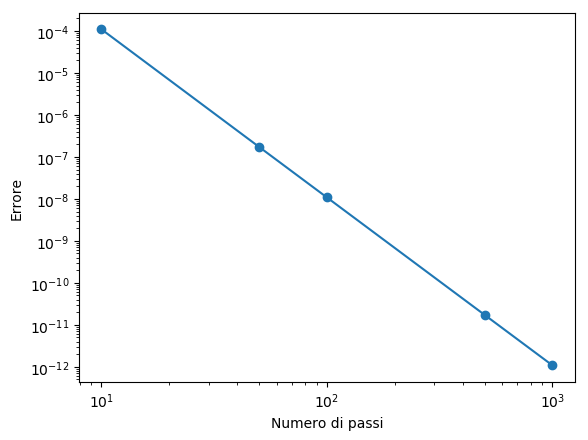

In [14]:
errors = compute_errors(simpson, steps)

loglog(steps, errors, "o-");
xlabel("Numero di passi");
ylabel("Errore");

In [15]:
error_slope(steps, errors)

-4.002400383183911

## Metodo dei trapezoidi

In questo caso si approssima l'integrale con l'area del trapezio.

In [16]:
function trapezoids(f, a, b, n::Integer)
    h = (b - a) / n
    acc = (f(a) + f(b)) / 2
    for k in 1:(n - 1)
        acc += f(a + k * h)
    end
    
    acc * h
end

trapezoids (generic function with 1 method)

In [17]:
trapezoids(sin, 0, pi, 10)

1.9835235375094546

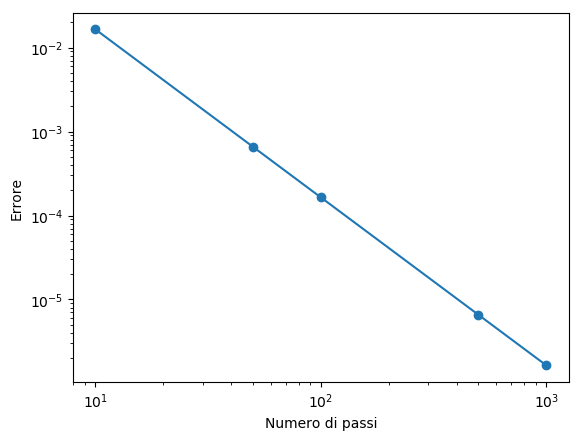

In [18]:
errors = compute_errors(trapezoids, steps)
loglog(steps, errors, "o-");
xlabel("Numero di passi");
ylabel("Errore");

In [19]:
error_slope(steps, errors)

-2.000357703753135

Tracciamo ora un grafico comparativo dei due metodi. È importante notare ancora una volta che qui stiamo usando il polimorfismo senza usare classi né metodi `virtual`. La funzione `compute_errors` infatti adatta il proprio comportamento a seconda della funzione che le viene passata come argomento (sia essa `midpoint`, `simpson`, o `trapezoids`).

Notate che anche in C++ è possibile avere polimorfismo senza usare classi, usando i template. Ma c'è una differenza importante: il polimorfismo con le classi è realizzato in fase di _runtime_ in C++, mentre quello con i template è realizzato in fase di _compilazione_. In Julia non c'è una distinzione rigida, e a seconda dei casi il compilatore sceglie se implementare il polimorfismo in fase di compilazione o runtime.

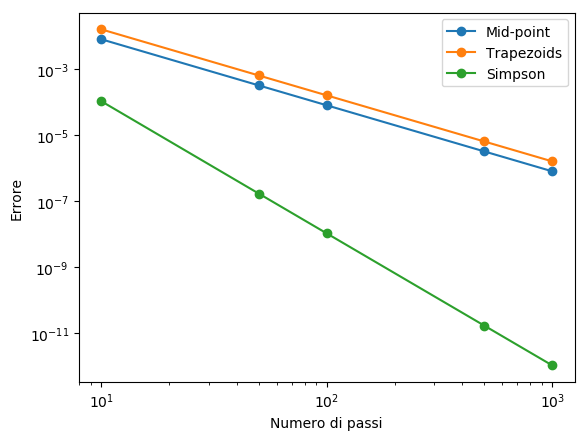

In [20]:
for (label, fn) in [
        ("Mid-point", midpoint),
        ("Trapezoids", trapezoids),
        ("Simpson", simpson),
    ]
    # All'interno di questo ciclo "for" sono definite le
    # due variabili "label" e "fn", che assumono uno dopo l'altro
    # il valore delle coppie elencate sopra tra parentesi. Notate
    # come in Julia sia semplicissimo iterare addirittura su liste
    # che contengono funzioni!
    loglog(steps, compute_errors(fn, steps), "o-", label=label)
end

xlabel("Numero di passi");
ylabel("Errore");
legend();

Notate che il metodo del mid-point e dei trapezi hanno la stessa legge di scala, ma non si sovrappongono: la costante $C$ nella legge di scala $\epsilon = C n^{-\alpha}$ è diversa (e quindi è diversa l'intercetta $q = \log C$ nel grafico bilogaritmico).

## Ricerca della precisione

L'esercizio 8.2 è diverso dagli esercizi 8.0 e 8.1, perché richiede di iterare il calcolo finché non si raggiunge una precisione fissata. Usiamo il suggerimento del testo per non dover ricalcolare da capo il valore approssimato dell'integrale.

Sfruttiamo la capacità di Julia di esprimere sequenze con la sintassi `start:delta:end`:

In [21]:
collect(1:2:10)

5-element Array{Int64,1}:
 1
 3
 5
 7
 9

Ora appare chiaro perché nell'implementare `midpoint`, `simpsons` e `trapezoids` sopra avevamo dichiarato esplicitamente il tipo dell'ultimo parametro, `n`: in questo caso vogliamo infatti invocare `trapezoids` usando la precisione, che indichiamo col tipo `AbstractFloat`, analogo a una classe astratta C++ da cui derivano i tipi floating-point, come `Float16`, `Float32`, e `Float64`.

In [22]:
function trapezoids(f, a, b, prec::AbstractFloat)
    n = 2
    
    h = (b - a) / n
    # Valore dell'integrale nel caso n = 2
    acc = (f(a) + f(b)) / 2 + f((a + b) / 2)
    newint = acc * h
    while true
        oldint = newint
        n *= 2
        h /= 2
        
        for k in 1:2:(n - 1) # Itera solo sui numeri dispari
            acc += f(a + k * h)
        end
        
        newint = acc * h
        # 4//3 è la frazione 4/3 in Julia
        if 4//3 * abs(newint - oldint) < prec
            break
        end
    end
    
    newint
end

trapezoids (generic function with 2 methods)

Notate che dopo aver compilato la definizione precedente, Julia ha scritto `trapezoids (generic function with 2 methods)`. Ha quindi capito che abbiamo fornito una nuova implementazione di `trapezoids`, e non ha quindi sovrascritto la vecchia (che accettava come ultimo argomento un intero, ossia il numero di passaggi).

Per verificare il funzionamento della nuova funzione `trapezoids`, possiamo verificare che l'integrale calcolato sulla nostra funzione di riferimento $f(x) = \sin x$ abbia un errore sempre inferiore alla precisione richiesta.

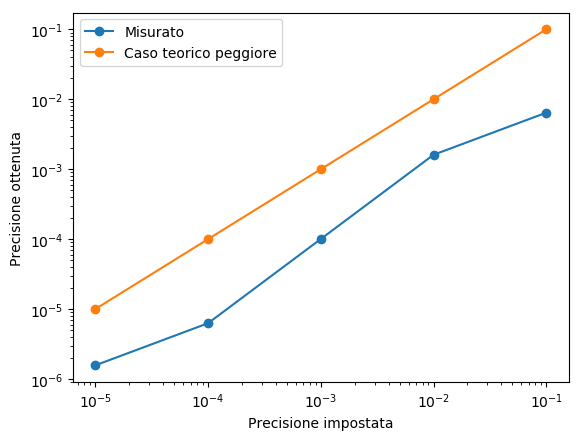

In [23]:
prec = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
errors = [abs(trapezoids(REF_FN, REF_A, REF_B, eps) - REF_INT)
          for eps in prec]

loglog(prec, errors, "o-", label="Misurato")
loglog(prec, prec, "o-", label="Caso teorico peggiore")
xlabel("Precisione impostata")
ylabel("Precisione ottenuta")
legend();